# Predicting Dengue Fever outbreaks in Singapore
### The Notebook is currently under work-in-progress
#### Contributors:
##### - Yuan Lai (https://github.com/ylurban)
##### - Diego Garzòn (https://github.com/Diegosmiles)
##### - Bilguun Turboli (https://github.com/bilguun)

In [49]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import warnings
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Phase 1

Disease data from: https://data.gov.sg/dataset/weekly-infectious-bulletin-cases

Weather data from: https://www.ncdc.noaa.gov/cdo-web/datatools/findstation; http://www.weather.gov.sg/climate-historical-daily/

In [2]:
dengue = pd.read_csv('weekly-infectious-bulletin-cases.csv')
np.unique(dengue.disease.values)

array(['Acute Viral hepatitis B', 'Acute Viral hepatitis C',
       'Avian Influenza', 'Campylobacterenterosis', 'Chikungunya Fever',
       'Cholera', 'Dengue Fever', 'Dengue Haemorrhagic Fever',
       'Diphtheria', 'Encephalitis', 'Haemophilus influenzae type b',
       'Hand, Foot Mouth Disease', 'Legionellosis', 'Malaria', 'Measles',
       'Melioidosis', 'Meningococcal Infection', 'Mumps',
       'Nipah virus infection', 'Paratyphoid', 'Pertussis', 'Plague',
       'Pneumococcal Disease (invasive)', 'Poliomyelitis', 'Rubella',
       'SARS', 'Salmonellosis(non-enteric fevers)', 'Typhoid',
       'Viral Hepatitis A', 'Viral Hepatitis E', 'Yellow Fever'], dtype=object)

In [3]:
# Subset to get Dengue info
dengue = dengue[(dengue.disease=='Dengue Fever')|(dengue.disease=='Dengue Haemorrhagic Fever')]
dengue.reset_index(inplace=True)

In [4]:
dengue.drop('index',axis=1,inplace=True)
dengue.head(1) # Start of records

,epi_week,disease,number_of_cases
0,2012-W01,Dengue Fever,74


In [5]:
dengue.tail(1) # End of records

,epi_week,disease,number_of_cases
437,2016-W10,Dengue Haemorrhagic Fever,1


In [6]:
dg = pd.DataFrame({'Cases':dengue.groupby('epi_week',axis=0)['number_of_cases'].sum()}).reset_index()
dg.head(1)

,epi_week,Cases
0,2012-W01,74


In [7]:
#wth = pd.read_csv('http://www1.ncdc.noaa.gov/pub/orders/cdo/707678.csv')
#wth.head(1) # Too many missing datapoints (-9999)

In [8]:
# Change source
# http://www.weather.gov.sg/climate-historical-daily/
files_=[]
data = {}
dir_ = 'WeatherData'
for directory,subdirectories,files in os.walk(dir_):
    for file_ in files:
        files_.append(os.path.join(dir_, file_))
        data[file_] = pd.read_csv((dir_+'/'+file_))

In [9]:
weather = pd.concat([data[i[12:]] for i in files_],axis=0,ignore_index=True)
# We only care about the daily means for temperature, rain and wind
weather.head(1)
#weather.to_csv('weather.csv')

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (�C),Maximum Temperature (�C),Minimum Temperature (�C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Changi,2012,1,1,0.6,�,�,�,27.2,31.4,25.2,8.4,28.4


In [10]:
weather = weather[['Station','Year','Month','Day',
    'Daily Rainfall Total (mm)','Mean Temperature (\xb0C)','Mean Wind Speed (km/h)']]
weather['Date'] = weather['Year'].astype(str)+'-'+weather['Month'].astype(str)+'-'+weather['Day'].astype(str)
weather['Date_T'] = pd.to_datetime(weather.Date,dayfirst=False).apply(lambda x: x.weekofyear)

In [11]:
weather['Mean Wind Speed (km/h)'] = weather['Mean Wind Speed (km/h)'].astype(str)

In [12]:
print (np.unique(weather['Mean Wind Speed (km/h)'].values)[-5:])
print type(weather['Mean Wind Speed (km/h)'][2])

['9.6' '9.7' '9.8' '9.9' '\x97']
<type 'str'>


In [13]:
# Non utf-8/ascii characters are causing problems: encoding is not working
for i in range(len(weather['Mean Wind Speed (km/h)'])):
    try:
        weather['Mean Wind Speed (km/h)'].iloc[i] = float(weather['Mean Wind Speed (km/h)'].iloc[i])
    except ValueError:
        weather['Mean Wind Speed (km/h)'].iloc[i] = np.nan

In [14]:
weather['Mean Wind Speed (km/h)'] = weather['Mean Wind Speed (km/h)'].astype(float)

In [15]:
wt = pd.DataFrame({'Mean_Rainfall':weather.groupby(['Year',
                   'Date_T'],axis=0)['Daily Rainfall Total (mm)'].mean(),
                  'Mean_Temperature':weather.groupby(['Year',
                   'Date_T'],axis=0)['Mean Temperature (\xb0C)'].mean(),
                  'Mean_Wind_Speed':weather.groupby(['Year',
                   'Date_T'],axis=0)['Mean Wind Speed (km/h)'].mean()}).reset_index()
wt.head(1)

,Year,Date_T,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
0,2012,1,13.35,26.7625,11.4875


In [16]:
weather[(weather['Year']==2016)&(weather['Date_T']==53)]

,Station,Year,Month,Day,Daily Rainfall Total (mm),Mean Temperature (�C),Mean Wind Speed (km/h),Date,Date_T
1461,Changi,2016,1,1,2.0,27.5,10.8,2016-1-1,53
1462,Changi,2016,1,2,39.6,25.7,6.8,2016-1-2,53
1463,Changi,2016,1,3,16.6,25.4,5.4,2016-1-3,53


In [17]:
# Prepare for merger
dg['Year'] = dg.epi_week.apply(lambda x: int(str(x)[:4]))
dg['Date_T'] = dg.epi_week.apply(lambda x: int(str(x)[-2:]))
# Merge
data = dg.merge(wt,on=['Year','Date_T'],how='inner')
data.head(1)
#data.to_csv('dengue_weather.csv')

,epi_week,Cases,Year,Date_T,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
0,2012-W01,74,2012,1,13.35,26.7625,11.4875


In [18]:
data.tail()

,epi_week,Cases,Year,Date_T,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
212,2016-W05,525,2016,5,5.571429,28.185714,11.685714
213,2016-W06,419,2016,6,0.314286,27.628571,10.542857
214,2016-W07,590,2016,7,10.428571,27.542857,11.514286
215,2016-W08,512,2016,8,10.257143,27.857143,12.342857
216,2016-W09,412,2016,9,0.000000,28.700000,16.900000


#### Analysis

In [19]:
col = np.sort(np.array(data['Year'].apply(lambda x: int(x)).unique()).flatten())
dt = pd.DataFrame(np.zeros, index=sorted(data['Date_T'].unique()), columns=(col))
# Populate with values
for i in dt.columns:
    for z in dt.index:
            temporary = data[(data['Date_T']==z)&(data['Year']==i)]
            try:
                dt.loc[z,i] = temporary.Cases.values[0].astype(float)
            except IndexError: # Because of index error
                pass
# Sanity check
print dt.shape 
dt_clean = dt.dropna()
print dt_clean.shape # No missing values 
dt_clean = dt_clean[[2012,2013,2014,2015]] # Because 2016 is incomplete, has to be omitted

(52, 5)
(52, 5)


In [20]:
for i in dt_clean.columns: # If some values are not numeric
    dt_clean[i] = dt_clean[i].convert_objects(convert_numeric=True)
    # Standardize dt
for i in dt_clean.index: # Standardize rows...
    dt_clean.loc[i] = (dt_clean.loc[i] - dt_clean.loc[i].mean())/dt_clean.loc[i].std()
# Find best number of clusters using the silhouette score
l = {}
for i in range(0,8): 
    est = KMeans(n_clusters = i+2, n_init = 100)
    est.fit(dt_clean.values)
    l[i] = silhouette_score(dt_clean.values, est.labels_)
    print('At {0} clusters, silhouette score is {1}'.format(i+2, l[i]))       

At 2 clusters, silhouette score is 0.496718126454
At 3 clusters, silhouette score is 0.507675356727
At 4 clusters, silhouette score is 0.449062522205
At 5 clusters, silhouette score is 0.462262928283
At 6 clusters, silhouette score is 0.453478319856
At 7 clusters, silhouette score is 0.476749834899
At 8 clusters, silhouette score is 0.449303970073
At 9 clusters, silhouette score is 0.459418755559


In [21]:
import operator
value = max(l.iteritems(), key=operator.itemgetter(1))[0]+2 # + 2 because clusters start at 2, not at 0 as the keys do

([<matplotlib.axis.XTick at 0x110bc8d10>,
 <a list of 3 Text xticklabel objects>)

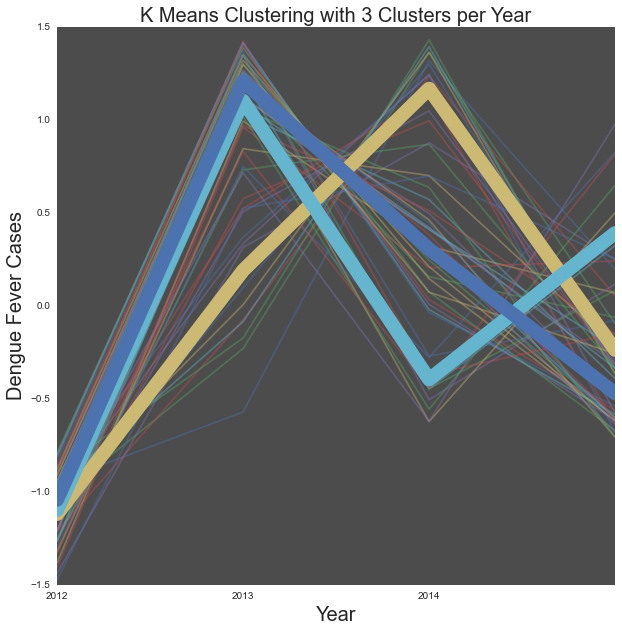

In [22]:
fig = plt.figure(figsize=(10,10))
kmeans = KMeans(n_clusters = value, n_init = 100)
kmeans.fit(dt_clean.values)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
ax = fig.add_subplot(111)
for a in dt_clean.index:
    plt.plot(dt_clean.loc[a].index,dt_clean.loc[a], alpha=0.4)
for b in range(len(centroids)):
    plt.plot(list(dt_clean.columns),centroids[b],linewidth=14)
ax.set_axis_bgcolor('#4C4C4C')
plt.xlim(dt_clean.columns.values.min(),dt_clean.columns.values.max())
plt.xlabel('Year',size=20)
plt.ylabel('Dengue Fever Cases',size=20)
plt.title("K Means Clustering with %i Clusters per Year" % (value), fontsize = 20)
ax.get_xaxis().tick_bottom();
locs, labels = plt.xticks();
ticks = np.arange(2012, 2015, 1);
ticks = [str(ticks[i]) for i in range(len(ticks))];
plt.grid('off')
plt.xticks(np.arange(2012, 2015, 1),ticks);
#plt.savefig('KMeans.jpg')

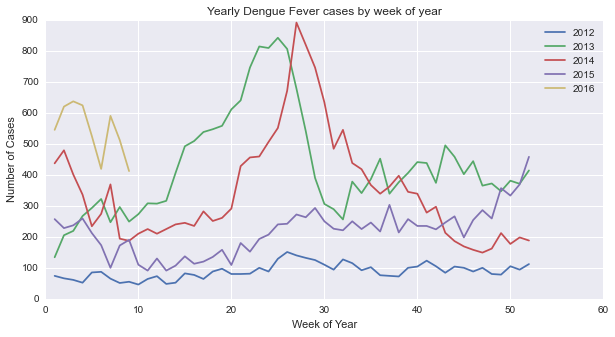

In [23]:
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Cases,label='%d'%(i));
    plt.legend();
    plt.title('Yearly Dengue Fever cases by week of year');
    plt.xlabel('Week of Year')
    plt.ylabel('Number of Cases')

***As one can see, some yearly pattern emerge. During the summer months, dengue cases are generally higher, except for 2015. Another spike appears at the end of the year, during winter months.***

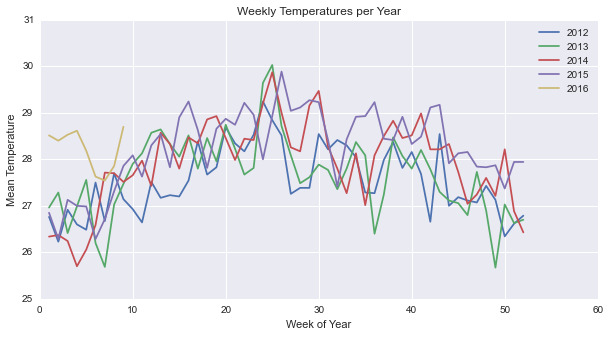

In [24]:
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Mean_Temperature,label='%d'%(i));
    plt.legend();
    plt.title('Weekly Temperatures per Year');
    plt.xlabel('Week of Year')
    plt.ylabel('Mean Temperature')

***At least the summer spikes coincide with higher temperatures. Let's see if this is true for wind and rainfall as well.***

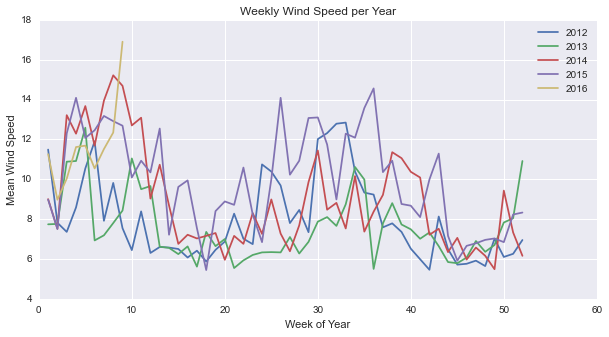

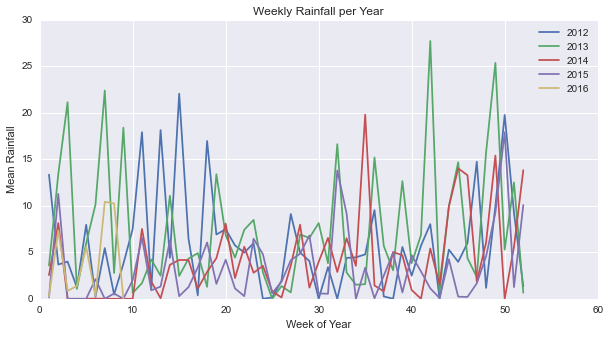

In [25]:
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Mean_Wind_Speed,label='%d'%(i));
    plt.legend();
    plt.title('Weekly Wind Speed per Year');
    plt.xlabel('Week of Year')
    plt.ylabel('Mean Wind Speed')
fig,ax = plt.subplots(figsize=(10,5))
for i in np.unique(data.Year.values):
    plt.plot(data[data.Year==i].Date_T,data[data.Year==i].Mean_Rainfall,label='%d'%(i));
    plt.legend();
    plt.title('Weekly Rainfall per Year');
    plt.xlabel('Week of Year')
    plt.ylabel('Mean Rainfall')

*** For rainfall, the patterns is less strong.***

In [26]:
data.drop(['Date_T','Year'],axis=1).corr()

,Cases,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
Cases,1.000000,-0.025574,0.239157,-0.079607
Mean_Rainfall,-0.025574,1.000000,-0.414773,-0.387488
Mean_Temperature,0.239157,-0.414773,1.000000,0.175892
Mean_Wind_Speed,-0.079607,-0.387488,0.175892,1.000000


***Indeed, the correlation matrix confirms the intuition drawn from the visualizations: Temperature is more correlated than rainfall and wind.***

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 216
Data columns (total 7 columns):
epi_week            217 non-null object
Cases               217 non-null int64
Year                217 non-null int64
Date_T              217 non-null int64
Mean_Rainfall       217 non-null float64
Mean_Temperature    217 non-null float64
Mean_Wind_Speed     217 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 13.6+ KB


In [28]:
data_clean = data.dropna()

In [29]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 0 to 216
Data columns (total 7 columns):
epi_week            217 non-null object
Cases               217 non-null int64
Year                217 non-null int64
Date_T              217 non-null int64
Mean_Rainfall       217 non-null float64
Mean_Temperature    217 non-null float64
Mean_Wind_Speed     217 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 13.6+ KB


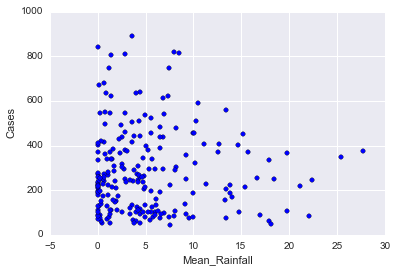

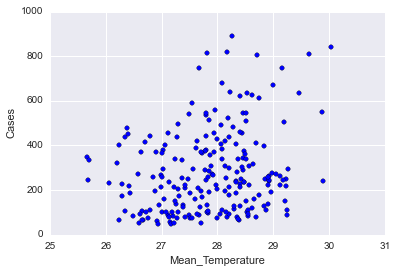

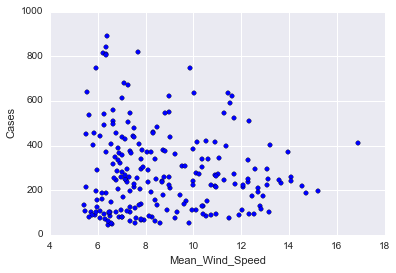

In [30]:
for i in data_clean.drop(['Date_T','Year','Cases','epi_week'],axis=1).columns:
    plt.figure()
    plt.scatter(data_clean[i],data_clean.Cases)
    plt.ylabel('Cases')
    plt.xlabel('%s'%(i))

In [31]:
data_clean[['Cases','Mean_Rainfall','Mean_Temperature','Mean_Wind_Speed']].describe()

,Cases,Mean_Rainfall,Mean_Temperature,Mean_Wind_Speed
count,217.000000,217.000000,217.000000,217.000000
mean,281.926267,5.194026,27.857340,8.756047
std,185.517255,5.480125,0.862754,2.433888
min,46.000000,0.000000,25.671429,5.442857
25%,125.000000,1.057143,27.242857,6.842857
50%,246.000000,3.971429,27.885714,8.042857
75%,381.000000,6.914286,28.457143,10.542857
max,891.000000,27.714286,30.028571,16.900000


In [32]:
# Use bins to reduce granularity but increase prediction accuracy

# Choose 0.5 C 
bins_temp = np.arange(data_clean.Mean_Temperature.min()-0.1,data_clean.Mean_Temperature.max()+0.1,0.5)
# Choose 50 cases
bins_cases = np.arange(data_clean.Cases.min()-4,data_clean.Cases.max()+4,50)
# Choose 0.5 km/h c
bins_wind = np.arange(data_clean.Mean_Wind_Speed.min()-0.3,data_clean.Mean_Wind_Speed.max()+0.3,0.5)
# Choose 0.5 km/h c
bins_rain = np.arange(data_clean.Mean_Rainfall.min()-1,data_clean.Mean_Rainfall.max()+1,1)


data_clean['Mean_Temperature_Bin'] = pd.cut(data_clean.Mean_Temperature, bins_temp, labels=np.arange(1,len(bins_temp),1))
data_clean['Cases_Bin'] = pd.cut(data_clean.Cases, bins_cases, labels=np.arange(1,len(bins_cases),1))
data_clean['Mean_Wind_Speed_Bin'] = pd.cut(data_clean.Mean_Wind_Speed, bins_wind, labels=np.arange(1,len(bins_wind),1))
data_clean['Mean_Rainfall_Bin'] = pd.cut(data_clean.Mean_Rainfall, bins_rain, labels=np.arange(1,len(bins_rain),1))

data_clean['Mean_Rainfall_Bin'] = data_clean['Mean_Rainfall_Bin'].astype(float)
data_clean['Mean_Temperature_Bin'] = data_clean['Mean_Temperature_Bin'].astype(float)
data_clean['Mean_Wind_Speed_Bin'] = data_clean['Mean_Wind_Speed_Bin'].astype(float)

# Alternative: Quantiles
#data_clean['Cases_Bin'] = pd.qcut(data_clean.Cases, 5, labels=np.arange(1,6,1))
#data_clean['Mean_Rainfall_Bin'] = pd.qcut(data_clean.Mean_Rainfall, 5, labels=np.arange(1,6,1))
#data_clean['Mean_Temperature_Bin'] = pd.qcut(data_clean.Mean_Temperature, 5, labels=np.arange(1,6,1))
#data_clean['Mean_Wind_Speed_Bin'] = pd.qcut(data_clean.Mean_Wind_Speed, 5, labels=np.arange(1,6,1))

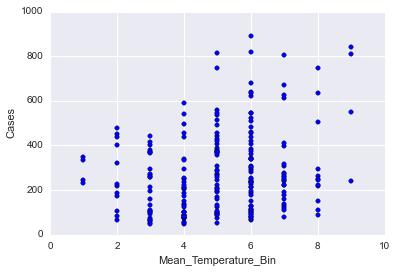

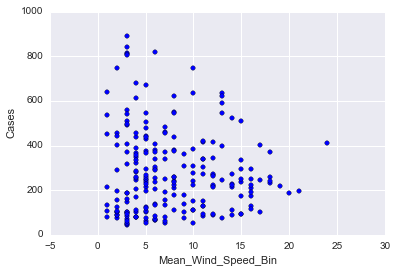

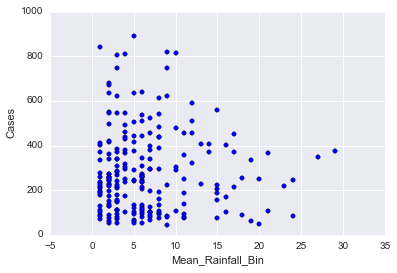

In [33]:
for i in data_clean.drop(['Date_T','Year','Cases','epi_week','Cases_Bin'],axis=1).columns:
    if i.find('Bin')!=-1:
        plt.figure()
        plt.scatter(data_clean[i],data_clean.Cases)
        plt.ylabel('Cases')
        plt.xlabel('%s'%(i))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(np.asarray(data_clean[['Mean_Rainfall_Bin',
                    'Mean_Temperature_Bin','Mean_Wind_Speed_Bin']]), np.asarray(data_clean.Cases_Bin), test_size=0.25)

In [35]:
print x_train.shape,x_test.shape,y_train.shape,y_test.shape

(162, 3) (55, 3) (162,) (55,)


In [36]:
# Naive Bayes
clf = GaussianNB()
clf.fit(x_train, y_train)
y_predict_train = clf.predict(x_train)
y_predict_test = clf.predict(x_test)
print 'Train Accuracy',100.0*accuracy_score(y_train,y_predict_train)
print 'Test Accuracy',100.0*accuracy_score(y_test,y_predict_test)

Train Accuracy 20.987654321
Test Accuracy 10.9090909091


In [37]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 2)
rf.fit(x_train, y_train)
y_pred_test = rf.predict(x_test)
print y_pred_test.shape
cm = confusion_matrix(y_test, y_pred_test)
print cm.shape
RFcm = cm
rfMSE = mean_squared_error(y_test, y_pred_test)

rfACC = (float(cm[0][0] + cm[1][1] + cm[2][2] + cm[3][3] + cm[4][4])) / (len(y_pred_test))

print "The Accuracy Rate is", rfACC
print "The Mean Squared Error is", rfMSE
print "The confusion matrix is:"
pd.crosstab(y_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

(55,)
(16, 16)
The Accuracy Rate is 0.0727272727273
The Mean Squared Error is 28.3636363636
The confusion matrix is:


Predicted,1,2,3,4,5,6,7,8,9,10,16,All
True,,,,,,,,,,,,
1,1,1,0,1,0,1,0,0,1,1,1,7
2,3,1,0,1,0,0,1,0,0,0,0,6
3,2,1,1,1,0,1,1,1,0,0,1,9
4,3,3,1,1,0,0,0,0,0,0,0,8
5,3,1,0,0,0,1,1,0,0,1,0,7
6,0,2,0,1,0,0,1,0,0,0,0,4
7,1,0,0,0,0,0,1,0,0,0,0,2
8,0,1,0,0,0,1,0,0,0,0,0,2
9,0,0,0,1,1,0,1,0,0,0,0,3


In [38]:
X = data_clean[['Mean_Rainfall_Bin','Mean_Temperature_Bin','Mean_Wind_Speed_Bin']]

In [39]:
X = np.asarray(X).reshape(len(X),3)
Y = np.asarray(data_clean.Cases_Bin.astype(float)).reshape(len(data_clean.Cases_Bin),)

In [40]:
A = np.random.randn(120/4,3).reshape((120/4,3))
B = np.random.randn(30)

In [41]:
print A.shape
print B.shape

(30, 3)
(30,)


In [ ]:
# Neural Network
from function_approximator import FunctionApproximator
from rnn import RNN, MetaRNN

n_hidden = 10 # M
n_in = 3      # D, number of variables taken in
n_out = 1     # K
n_steps = len(data_clean)  # the length of each sequence
n_seq = 1   # the number of datapoints (i.e. sequences)

X = np.array(X).reshape((n_seq, n_steps, n_in))
Y = np.array(Y).reshape(n_seq, n_steps, n_out)

#fa = FunctionApproximator(n_in=4, n_out=1, n_hidden=2, activation=None)
#fa.train(A,B, learning_rate=0.017, n_epochs=40000, report_frequency=5000)
#Y_pred = fa.get_y_pred()

print (X.shape)
print (Y.shape)
model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.1, learning_rate_decay=0.999,
                    n_epochs=10000, activation='tanh')
model.fit(X, Y, validation_frequency=5000)

In [ ]:
Y_pred_RNN = model.predict(X[0])

In [ ]:
print 'Accuracy',100.0*sum(Y_pred_RNN==data_clean.Cases_Bin)/len(Y_pred_RNN)

### Lag data

Because the life cycle of mosquito's lasts about 10 days, we will lag the weather related data by one week and later, by two weeks. Reference:
http://www.cdc.gov/Dengue/entomologyEcology/m_lifecycle.html

In [99]:
def shift(n):
    lag = data_clean.copy()
    desired_columns = ['Mean_Rainfall','Mean_Temperature', 'Mean_Wind_Speed', 'Mean_Temperature_Bin', 
          'Mean_Wind_Speed_Bin', 'Mean_Rainfall_Bin']
    for i in desired_columns:
        lag[i] = lag[i].shift(n)
    l = list(np.arange(0,n,1) )
    for i in l:
        lag.drop(i,axis=0,inplace=True)
    X = np.asarray(lag[['Mean_Rainfall_Bin',
                        'Mean_Temperature_Bin','Mean_Wind_Speed_Bin']])
    Y = np.asarray(lag.Cases_Bin)
    return X,Y

In [79]:
# Naive Bayes
def naive_bayes(X,Y):    
    kf = KFold(len(X), n_folds=15, shuffle=True, indices=True)
    clf = GaussianNB()
    performance = ([clf.fit(X[train_indices], Y[train_indices]).score(X[test_indices],
        Y[test_indices])for train_indices, test_indices in kf])

    summary = [np.min(performance),np.mean(performance),np.max(performance)]
    return summary

In [101]:
X,Y = shift(1)
dt = naive_bayes(X,Y)
print 'lag1',dt

lag1 [0.066666666666666666, 0.13873015873015873, 0.26666666666666666]


##### Use ROC to compare algorithms:
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
##### Try:
- SVM Regression

### Phase 2

KML to GeoJson:
    
    ogr2ogr -f GeoJSON name.json name.kml

In [ ]:
bins = gpd.GeoDataFrame.from_file('recyclingbins.json')
waterfacilities = gpd.GeoDataFrame.from_file('waterfacilities.json')
parks = gpd.GeoDataFrame.from_file('parks.json')
d_clusters = gpd.GeoDataFrame.from_file('dengue_clusters.json')

In [ ]:
# check if datasets haev similar mapping
print 'bins',len(bins),bins.crs # Number of bins in Singapore
print 'waterfacilities',len(waterfacilities),waterfacilities.crs # Number of facilities in Singapore
print 'parks',len(parks),parks.crs # Number of parks in Singapore
print 'dengue clusters',len(d_clusters),d_clusters.crs # Number of cases in Singapore

In [ ]:
d_clusters.head()

In [ ]:
d_clusters.plot()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
bins.plot(axes=ax) # Visualization Bins
waterfacilities.plot(axes=ax, color='b', linewidth=6) # Visualization Facilities
parks.plot(axes=ax,color='g', linewidth=10)